<a href="https://colab.research.google.com/github/Murataydinunimi/MarketBasketAnalysis-Pyspark/blob/main/MBA-PySpark-Aydin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Finding frequent itemsets (IMDB) <br>
Enki Muca<br>
DSE 2021/2022

In [ ]:
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# download spark3.0.2
!wget -q http://apache.osuosl.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop3.2.tgz

# unzip it
!tar xf spark-3.0.3-bin-hadoop3.2.tgz
# install findspark 
!pip install -q findspark

In [ ]:
!pip install kaggle

In [ ]:
# Kaggle API to download the dataset
import os
kaggle_api = {"username":"murataydn","key":"7c7468d4948d474d251b85a914a9cf8e"}
os.environ['KAGGLE_USERNAME'] = kaggle_api['username']
os.environ['KAGGLE_KEY'] = kaggle_api['key'] 

In [ ]:
!kaggle datasets download -d bwandowando/ukraine-russian-crisis-twitter-dataset-1-2-m-rows

ukraine-russian-crisis-twitter-dataset-1-2-m-rows.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip ukraine-russian-crisis-twitter-dataset-1-2-m-rows

Archive:  ukraine-russian-crisis-twitter-dataset-1-2-m-rows.zip
replace UkraineCombinedTweetsDeduped20220227-131611.csv.gzip? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import numpy as np
import pandas as pd
import csv
import os


In [ ]:
data_to_read = ["UkraineCombinedTweetsDeduped_FEB28_part1.csv.gzip",
                "UkraineCombinedTweetsDeduped_FEB28_part2.csv.gzip",
                "UkraineCombinedTweetsDeduped_MAR01.csv.gzip",
                "UkraineCombinedTweetsDeduped_MAR02.csv.gzip",
                "UkraineCombinedTweetsDeduped_MAR03.csv.gzip",
                "UkraineCombinedTweetsDeduped_MAR04.csv.gzip",
                "UkraineCombinedTweetsDeduped_MAR05.csv.gzip"]

In [ ]:
data_collection = []

columns = ["userid","text","language"]

for data in data_to_read:


  df = pd.read_csv(data, compression='gzip', index_col=0,encoding='utf-8', quoting=csv.QUOTE_ALL, low_memory=False)
  df= df[columns]
  data_collection.append(df)
  print(f"The data {data} has {len(df)} number of rows ")



    
    

The data UkraineCombinedTweetsDeduped_FEB28_part1.csv.gzip has 237787 number of rows 
The data UkraineCombinedTweetsDeduped_FEB28_part2.csv.gzip has 140384 number of rows 
The data UkraineCombinedTweetsDeduped_MAR01.csv.gzip has 409279 number of rows 
The data UkraineCombinedTweetsDeduped_MAR02.csv.gzip has 417031 number of rows 
The data UkraineCombinedTweetsDeduped_MAR03.csv.gzip has 395772 number of rows 
The data UkraineCombinedTweetsDeduped_MAR04.csv.gzip has 480290 number of rows 
The data UkraineCombinedTweetsDeduped_MAR05.csv.gzip has 546780 number of rows 


In [ ]:
df_combined = pd.concat(data_collection, axis=0)
df_combined.shape

(2627323, 3)

In [ ]:
df_combined.drop_duplicates(subset=['text'],keep='last',inplace=True)
df_combined.shape


(853217, 3)

In [ ]:
df_combined =  df_combined[df_combined["language"] == "en"]
df_combined.shape

(511565, 3)

In [ ]:
df.columns

Index(['userid', 'text', 'language'], dtype='object')

In [ ]:
df_combined.head()

,userid,text,language
1498827,2170195636,Closer look at the Vasylkiv oil depot fire whi...,en
1498832,1426649188222308355,Ireland to close its airspace to Russian air t...,en
1498834,2544474997,Ukrainian National Anthem with English transla...,en
1498845,2225131633,@FoxNews Everything COUNTS🙏\nwhen #Putin puts ...,en
1498851,867133740,@carlbildt Gosh! Now #Putin's doing the two fl...,en


In [ ]:
!pip install pyspark


In [ ]:

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
spark = SparkSession.builder.enableHiveSupport().getOrCreate()


In [ ]:

from pyspark.sql import SQLContext

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")





In [ ]:
sc = spark.sparkContext


In [ ]:
spark_eng=spark.createDataFrame(df_combined) 
spark_eng.createOrReplaceTempView("spark_eng")
spark_eng.show(10)

+-------------------+--------------------+--------+
|             userid|                text|language|
+-------------------+--------------------+--------+
|         2170195636|Closer look at th...|      en|
|1426649188222308355|Ireland to close ...|      en|
|         2544474997|Ukrainian Nationa...|      en|
|         2225131633|@FoxNews Everythi...|      en|
|          867133740|@carlbildt Gosh! ...|      en|
|1461557439011168260|There are a lot o...|      en|
|           65671909|Not too fast budd...|      en|
| 895360710623887360|have you noticed ...|      en|
|1370059737551736842|they are really m...|      en|
|         3395130700|I can not believe...|      en|
+-------------------+--------------------+--------+
only showing top 10 rows



In [ ]:
spark_eng.cache()

DataFrame[userid: bigint, text: string, language: string]

In [ ]:
from pyspark.sql.functions import regexp_replace, trim, col, lower

def removePunctuation(column):
   return lower(trim(regexp_replace(column,'\\p{Punct}',''))).alias('sentence')

spark_eng = spark_eng.select("userid",removePunctuation(col('text')).alias("text"))
spark_eng.show(5)

+-------------------+--------------------+
|             userid|                text|
+-------------------+--------------------+
|         2170195636|closer look at th...|
|1426649188222308355|ireland to close ...|
|         2544474997|ukrainian nationa...|
|         2225131633|foxnews everythin...|
|          867133740|carlbildt gosh no...|
+-------------------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import trim,split,explode,col


tokenizer = Tokenizer(inputCol='text', outputCol='words_token')
spark_eng = spark_eng.withColumn("text", trim(col("text")))
spark_eng = tokenizer.transform(spark_eng)
spark_eng.show()

+-------------------+--------------------+--------------------+
|             userid|                text|         words_token|
+-------------------+--------------------+--------------------+
|         2170195636|closer look at th...|[closer, look, at...|
|1426649188222308355|ireland to close ...|[ireland, to, clo...|
|         2544474997|ukrainian nationa...|[ukrainian, natio...|
|         2225131633|foxnews everythin...|[foxnews, everyth...|
|          867133740|carlbildt gosh no...|[carlbildt, gosh,...|
|1461557439011168260|there are a lot o...|[there, are, a, l...|
|           65671909|not too fast budd...|[not, too, fast, ...|
| 895360710623887360|have you noticed ...|[have, you, notic...|
|1370059737551736842|they are really m...|[they, are, reall...|
|         3395130700|i can not believe...|[i, can, not, bel...|
| 947512131729096705|georgegalloway wa...|[georgegalloway, ...|
|         2571956359|352 ukrainians am...|[352, ukrainians,...|
|1466368139357302786|anyone know how t..

In [ ]:
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
spark_eng = remover.transform(spark_eng).select("userid","text",'words_clean')
spark_eng.select("words_clean").show(truncate=False)


+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|words_clean                                                                                                                                                                                                                                                                 |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[closer, look, vasylkiv, oil, depot, fire, occured, last, night, result, russian, strikes, osint, russia, ukraine, httpstcoe0re0foxqf]                                                    

In [ ]:
from pyspark.sql.functions import expr

spark_eng = spark_eng.withColumn("words_clean", expr("filter(words_clean, elem -> elem != '')"))
spark_eng.show(10)

+-------------------+--------------------+--------------------+
|             userid|                text|         words_clean|
+-------------------+--------------------+--------------------+
|         2170195636|closer look at th...|[closer, look, va...|
|1426649188222308355|ireland to close ...|[ireland, close, ...|
|         2544474997|ukrainian nationa...|[ukrainian, natio...|
|         2225131633|foxnews everythin...|[foxnews, everyth...|
|          867133740|carlbildt gosh no...|[carlbildt, gosh,...|
|1461557439011168260|there are a lot o...|[lot, airstrikes,...|
|           65671909|not too fast budd...|[fast, buddy, don...|
| 895360710623887360|have you noticed ...|[noticed, many, p...|
|1370059737551736842|they are really m...|[really, making, ...|
|         3395130700|i can not believe...|[believe, man, fi...|
+-------------------+--------------------+--------------------+
only showing top 10 rows



In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType,StringType

get_uniques=udf(lambda x: list(set(x)), ArrayType(StringType()))

spark_eng = spark_eng.withColumn("words_clean", get_uniques(spark_eng.words_clean))
spark_eng.show(10)

+-------------------+--------------------+--------------------+
|             userid|                text|         words_clean|
+-------------------+--------------------+--------------------+
|         2170195636|closer look at th...|[result, look, st...|
|1426649188222308355|ireland to close ...|[httpstco5hqjb7vr...|
|         2544474997|ukrainian nationa...|[ukrainerussiacri...|
|         2225131633|foxnews everythin...|[nukes, counts🙏,...|
|          867133740|carlbildt gosh no...|[two, flags, puti...|
|1461557439011168260|there are a lot o...|[kievukraine, htt...|
|           65671909|not too fast budd...|[hand, fast, iran...|
| 895360710623887360|have you noticed ...|[paste, stuff, co...|
|1370059737551736842|they are really m...|[really, savesilw...|
|         3395130700|i can not believe...|[fuckus, united, ...|
+-------------------+--------------------+--------------------+
only showing top 10 rows



In [ ]:
num_baskets = spark_eng.groupBy("userid").count()
num_baskets.orderBy("count",ascending=False).show(10)

+-------------------+-----+
|             userid|count|
+-------------------+-----+
|1221797851258163200| 1113|
|           88196314|  667|
|1260888402993598467|  544|
|         4828915804|  400|
|1164907412630827008|  346|
|1456228393234493446|  337|
| 915351016366845952|  334|
|1178811384387293187|  316|
|1490088025430315012|  297|
|1470034927609696259|  296|
+-------------------+-----+
only showing top 10 rows



In [ ]:
from pyspark.sql.functions import size, explode, col, split
from pyspark.sql import functions as F

num_items = spark_eng.select('*',size('words_clean').alias('Numberofwords'))
num_items =num_items.groupby("userid").agg(F.sum("Numberofwords").alias('Numberofwords')).orderBy("Numberofwords",ascending=False)
num_items.show(10)

+-------------------+-------------+
|             userid|Numberofwords|
+-------------------+-------------+
|1221797851258163200|        25500|
|1260888402993598467|         9451|
|           88196314|         7094|
|         4828915804|         6764|
|1164907412630827008|         5922|
|1284576972438478849|         5679|
|1178811384387293187|         5533|
|1290210901543596035|         5410|
|1493243178933051392|         4940|
|1203552378382934016|         4902|
+-------------------+-------------+
only showing top 10 rows



In [ ]:
num_items.agg(F.sum("Numberofwords")).collect()[0][0]


8657149

In [ ]:
spark_eng = spark_eng.drop("userid")
spark_eng.show()

+--------------------+--------------------+
|                text|         words_clean|
+--------------------+--------------------+
|closer look at th...|[result, look, st...|
|ireland to close ...|[httpstco5hqjb7vr...|
|ukrainian nationa...|[ukrainerussiacri...|
|foxnews everythin...|[nukes, counts🙏,...|
|carlbildt gosh no...|[two, flags, puti...|
|there are a lot o...|[kievukraine, htt...|
|not too fast budd...|[hand, fast, iran...|
|have you noticed ...|[paste, stuff, co...|
|they are really m...|[really, savesilw...|
|i can not believe...|[fuckus, united, ...|
|georgegalloway wa...|[logic, europe, i...|
|352 ukrainians am...|[14, pray, blood,...|
|anyone know how t...|[httpstco3qjryrtc...|
|another soviet ru...|[prelude, another...|
|trollbot activity...|[feed, accidently...|
|glennkirschner2 j...|[nuts, get, donal...|
|russia’s central ...|[ukraineunderatta...|
|nato warns russia...|[dire, masks, fol...|
|anonymous the hac...|[hacker, collecti...|
|repboebert a real...|[shes, walk

In [ ]:
import time
from tqdm import tqdm
from pyspark.ml.fpm import FPGrowth

In [ ]:
np.random.seed(1)
# Try different thresholds for minimum support 
th_res = [0.01,0.02,0.06,0.09,0.1]
fpgrowth_time_res = {}

for th in tqdm( th_res ):

  #key = str(round(th*1000))

  fpGrowth = FPGrowth(itemsCol="words_clean", minSupport = th)

  # compute time difference
  start_time = time.time()
  model = fpGrowth.fit(spark_eng)

  fpgrowth_time_res[th] = time.time() - start_time


100%|██████████| 5/5 [07:21<00:00, 88.38s/it]


In [ ]:
fpgrowth_time_res

{0.01: 97.76321315765381,
 0.02: 85.43229508399963,
 0.06: 84.3704743385315,
 0.09: 89.57898211479187,
 0.1: 84.66933679580688}

In [ ]:
from pyspark.sql.types import StructType,StructField

fp_th_res = spark.createDataFrame(fpgrowth_time_res.items(), 
                      schema=StructType(fields=[
                          StructField("Threshold", StringType()), 
                          StructField("Time Elapsed(seconds)", StringType())]))
fp_th_res.show()

+---------+---------------------+
|Threshold|Time Elapsed(seconds)|
+---------+---------------------+
|     0.01|    97.76321315765381|
|     0.02|    85.43229508399963|
|     0.06|     84.3704743385315|
|     0.09|    89.57898211479187|
|      0.1|    84.66933679580688|
+---------+---------------------+



In [ ]:
# Try different fraction of the dataframe
size_sample = [0.1,0.3,0.5,0.7,0.9]
fpgrowth_time_res_frac = {}
for fr in tqdm(size_sample):
    # extract a fraction of the dataframe
    df_frac = spark_eng.sample(False, fr, seed = 1)
    fpGrowth = FPGrowth(itemsCol = 'words_clean', minSupport = 0.02)
    start_time = time.time()
    model = fpGrowth.fit(df_frac)   
    fpgrowth_time_res_frac[fr] = time.time() - start_time

100%|██████████| 5/5 [03:56<00:00, 47.37s/it]


In [ ]:
from pyspark.sql.types import StructType,StructField

fp_frac_res = spark.createDataFrame(fpgrowth_time_res_frac.items(), 
                      schema=StructType(fields=[
                          StructField("Fraction", StringType()), 
                          StructField("Time Elapsed(seconds)", StringType())]))


fp_frac_res.show()

+--------+---------------------+
|Fraction|Time Elapsed(seconds)|
+--------+---------------------+
|     0.1|    42.86704349517822|
|     0.3|    47.70837998390198|
|     0.5|    39.17559576034546|
|     0.7|    48.38686490058899|
|     0.9|   58.607359409332275|
+--------+---------------------+



In [ ]:
np.random.seed(1)

fpGrowth = FPGrowth(itemsCol="words_clean", minSupport = 0.04)
model = fpGrowth.fit(spark_eng)
association_rules = model.associationRules
frequent_items = model.freqItemsets

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [ ]:
frequent_items.orderBy("freq",ascending=False).show(15,truncate=False)

+------------------+------+
|items             |freq  |
+------------------+------+
|[ukraine]         |320002|
|[russia]          |166416|
|[russia, ukraine] |111956|
|[putin]           |107214|
|[russian]         |92945 |
|[war]             |64892 |
|[russian, ukraine]|62470 |
|[putin, ukraine]  |62073 |
|[ukrainerussiawar]|59361 |
|[nato]            |50164 |
|[stop]            |45816 |
|[people]          |43362 |
|[war, ukraine]    |42929 |
|[stopputin]       |39778 |
|[ukrainian]       |38344 |
+------------------+------+
only showing top 15 rows



In [ ]:
frequent_items.count()

59

In [ ]:
association_rules.show(15,truncate=False)

+-----------------+----------+------------------+------------------+--------------------+
|antecedent       |consequent|confidence        |lift              |support             |
+-----------------+----------+------------------+------------------+--------------------+
|[close]          |[ukraine] |0.9186210911510313|1.468600067798409 |0.043183173203796194|
|[close]          |[sky]     |0.8521290751829674|18.85056909604215 |0.04005747070264776 |
|[humanitarian]   |[ukraine] |0.928794201625302 |1.4848638253761004|0.04133199104708102 |
|[stopputin]      |[ukraine] |0.8529589220171955|1.3636259201649017|0.0663239275556381  |
|[potus]          |[ukraine] |0.837628134363665 |1.3391165811085048|0.05191324660600315 |
|[nato, russia]   |[ukraine] |0.8385143474236347|1.3405333704381779|0.042498998172275274|
|[stopputin, stop]|[ukraine] |0.9505586706503499|1.51965869454869  |0.04539990030592398 |
|[stop]           |[ukraine] |0.8121398638030383|1.2983684682750642|0.07273562499389129 |
|[weapons]

In [ ]:
fp_th_pd = fp_th_res.toPandas()

fp_frac_pd = fp_frac_res.toPandas()


In [ ]:
fp_th_pd["Threshold"] = pd.to_numeric(fp_th_pd["Threshold"])
fp_th_pd["Time Elapsed(seconds)"] = pd.to_numeric(fp_th_pd["Time Elapsed(seconds)"])


Text(0, 0.5, 'Seconds')

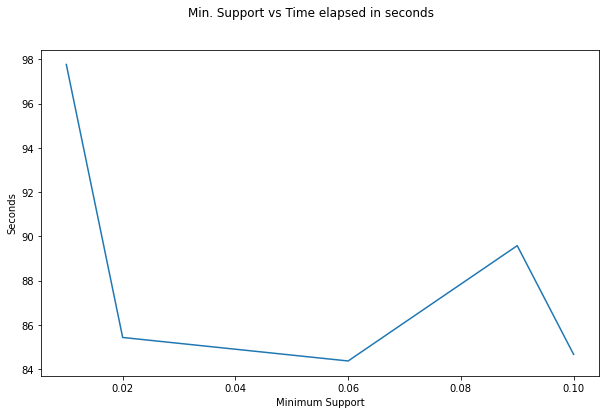

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10,6]

fig = plt.figure()
plt.plot(fp_th_pd["Threshold"],fp_th_pd["Time Elapsed(seconds)"])
fig.suptitle('Min. Support vs Time elapsed in seconds')
plt.xlabel('Minimum Support')
plt.ylabel('Seconds')


In [ ]:
fp_frac_pd["Fraction"] = pd.to_numeric(fp_frac_pd["Fraction"])
fp_frac_pd["Time Elapsed(seconds)"] = pd.to_numeric(fp_frac_pd["Time Elapsed(seconds)"])

Text(0, 0.5, 'Seconds')

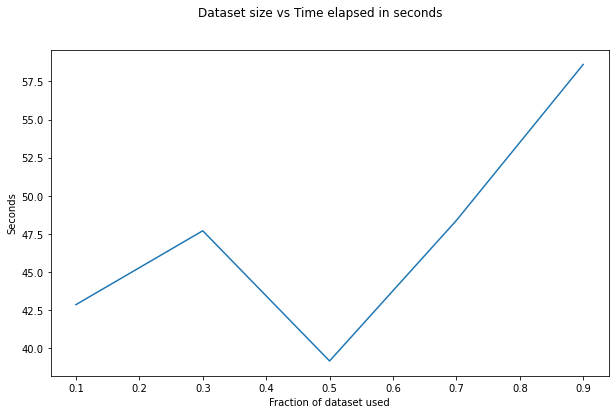

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10,6]

fig = plt.figure()
plt.plot(fp_frac_pd["Fraction"],fp_frac_pd["Time Elapsed(seconds)"])
fig.suptitle('Dataset size vs Time elapsed in seconds')
plt.xlabel('Fraction of dataset used')
plt.ylabel('Seconds')


In [ ]:
words_basket = spark_eng.select('words_clean').collect()


list_words_baskets = [ row[0] for row in words_basket]

# Save the actor baskets list
f = open('list_words_baskets.txt','w')
for el in list_words_baskets:
    f.write(str(el)+'\n')
f.close()

In [ ]:
my_file = open("list_words_baskets.txt", "r")
list_loaded = my_file.readlines()
list_words_baskets = [eval(el) for el in list_loaded]

In [ ]:
indices = range(0,10000)
try_set = [list_words_baskets[i] for i in indices]
len(try_set)

10000

In [ ]:
#Free RAM
del(spark)
del(sc)
del(num_items)
del(num_baskets)
del(spark_eng)
del(data_collection)
del(df_combined)
del(SparkSession)
del(SparkConf)
del(SparkContext)
del(FPGrowth)

NameError: ignored

In [ ]:
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
import plotly.express as px
from tqdm import tqdm
import pandas as pd
import numpy as np
import time 

In [ ]:
th_res = [0.01,0.02,0.06,0.09,0.1]
apriori_time_res = {}
for th in th_res:
    te = TransactionEncoder()
    oht_ary = te.fit(try_set).transform(try_set, sparse=True)
    sparse_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)
    start_time = time.time()
    res= apriori(sparse_df, min_support=th, use_colnames=True)
    apriori_time_res[th] = time.time() - start_time

In [ ]:
apriori_time_res

{0.01: 155.2112021446228,
 0.02: 14.014213800430298,
 0.06: 13.663833856582642,
 0.09: 13.586296081542969,
 0.1: 13.621819257736206}

In [ ]:
ap_th_res = pd.DataFrame.from_dict(apriori_time_res, orient="index").reset_index()

new_column_list= ["Threshold","Time Elapsed"]

ap_th_res = ap_th_res.set_axis(new_column_list, axis=1)
ap_th_res

,Threshold,Time Elapsed
0,0.01,155.211202
1,0.02,14.014214
2,0.06,13.663834
3,0.09,13.586296
4,0.10,13.621819


In [ ]:
te = TransactionEncoder()
oht_ary = te.fit(try_set).transform(try_set, sparse=True)
sparse_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)
res= apriori(sparse_df, min_support=0.04, use_colnames=True)


In [ ]:
len(res)

49

In [ ]:
te = TransactionEncoder()
oht_ary = te.fit(try_set).transform(try_set, sparse=True)
sparse_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)
res= apriori(sparse_df, min_support=0.02, use_colnames=True)


In [ ]:
len(res)

194

In [ ]:
res.sort_values(by=['support'],ascending=False).head(10)

,support,itemsets
56,0.6397,(ukraine)
40,0.3512,(russia)
124,0.2496,"(russia, ukraine)"
37,0.2461,(putin)
41,0.1807,(russian)
59,0.1762,(ukrainerussiawar)
118,0.1430,"(putin, ukraine)"
134,0.1325,"(russian, ukraine)"
67,0.1235,(war)
146,0.1033,"(ukrainerussiawar, ukraine)"


In [ ]:
fraction_sample = [0.1,0.3,0.5,0.7,0.9]
apriori_time_res_frac = {}
for fr in tqdm(fraction_sample):
    list_frac = try_set[0:round(fr*len(try_set))]
    print(len(list_frac))
    te = TransactionEncoder() 
    oht_ary = te.fit(list_frac).transform(list_frac, sparse=True)
    sparse_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)
    start_time = time.time()
    res= apriori(sparse_df, min_support=0.04, use_colnames=True)
    apriori_time_res_frac[fr] = time.time() - start_time

  0%|          | 0/5 [00:00<?, ?it/s]

1000


 20%|██        | 1/5 [00:00<00:03,  1.11it/s]

3000


 40%|████      | 2/5 [00:04<00:07,  2.36s/it]

5000


 60%|██████    | 3/5 [00:14<00:12,  6.13s/it]

7000


 80%|████████  | 4/5 [00:30<00:09,  9.83s/it]

9000


100%|██████████| 5/5 [00:50<00:00, 10.17s/it]


In [ ]:
apriori_time_res_frac

{0.1: 0.6691908836364746,
 0.3: 2.8909659385681152,
 0.5: 8.359999418258667,
 0.7: 14.521827936172485,
 0.9: 19.26300048828125}

In [ ]:
apriori_time_res_frac = pd.DataFrame.from_dict(apriori_time_res_frac, orient="index").reset_index()

new_column_list= ["Fraction","Time Elapsed"]

apriori_time_res_frac = apriori_time_res_frac.set_axis(new_column_list, axis=1)
apriori_time_res_frac

,Fraction,Time Elapsed
0,0.1,0.669191
1,0.3,2.890966
2,0.5,8.359999
3,0.7,14.521828
4,0.9,19.263000


Text(0, 0.5, 'Seconds')

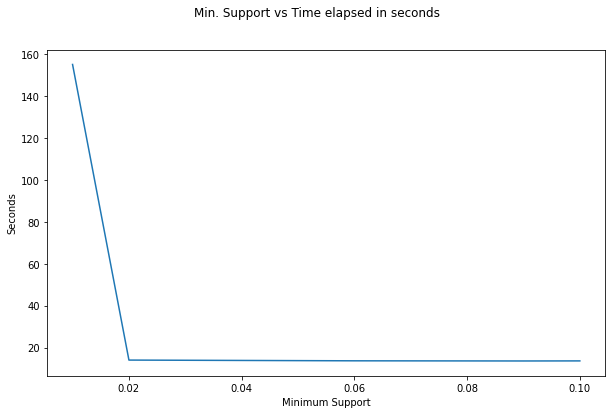

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10,6]

fig = plt.figure()
plt.plot(ap_th_res["Threshold"],ap_th_res["Time Elapsed"])
fig.suptitle('Min. Support vs Time elapsed in seconds')
plt.xlabel('Minimum Support')
plt.ylabel('Seconds')


Text(0, 0.5, 'Seconds')

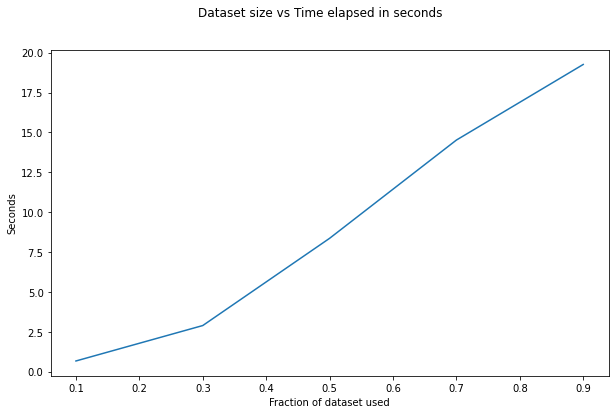

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10,6]

fig = plt.figure()
plt.plot(apriori_time_res_frac["Fraction"],apriori_time_res_frac["Time Elapsed"])
fig.suptitle('Dataset size vs Time elapsed in seconds')
plt.xlabel('Fraction of dataset used')
plt.ylabel('Seconds')
